# Vision Zero: Quick read on bike + ped crashes

- Get a feel for where bike crashes happen and how
- Spot the biggest drivers of ped crashes
- End with a shortlist of what to try next

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
pd.options.display.float_format = lambda x: f"{x:,.1f}"

In [2]:
# Load the datasets
crash_incident = pd.read_csv('testdb_dbo_crash_incident.csv', low_memory=False)
party = pd.read_csv('testdb_dbo_party.csv')

print(f"crash_incident: {crash_incident.shape[0]:,} rows, {crash_incident.shape[1]} cols")
print(f"party:          {party.shape[0]:,} rows, {party.shape[1]} cols")

crash_incident.head(3)

crash_incident: 328,327 rows, 14 cols
party:          682,280 rows, 7 cols


,id,is_intersection,is_bicycle_crash,is_pedestrian_crash,is_motorcycle_crash,is_truck_crash,date,category,severity,ped_action,primary_factor,road_condition,weather,lighting
0,5997135,False,NaN,NaN,NaN,NaN,2013-01-27 00:00:00.000,Sideswipe,Injury (Complaint of Pain),No Pedestrian Involved,Unsafe Lane Change,No Unusual Condition,Clear,Daylight
1,5997139,False,NaN,NaN,NaN,NaN,2013-01-31 00:00:00.000,Rear End,Injury (Complaint of Pain),No Pedestrian Involved,Unsafe Speed,No Unusual Condition,Clear,Dark - Street Lights
2,5997159,False,NaN,NaN,NaN,NaN,2013-01-29 00:00:00.000,Sideswipe,Injury (Complaint of Pain),No Pedestrian Involved,Unsafe Lane Change,No Unusual Condition,Clear,Daylight


In [3]:
# Quick look at categories
crash_incident['category'].value_counts(dropna=False).head(10).rename('count')

category
Rear End              110090
Broadside              70525
Hit Object             40241
Sideswipe              34635
Vehicle/Pedestrian     27611
Head-On                18235
Overturned             11808
Other                  11311
Not Stated              3868
                           3
Name: count, dtype: int64

## Tidy categories

Grouping a few detailed crash types into broader buckets so plots read cleanly.

In [4]:
# Map detailed categories into broader buckets
category_mapping = {
    'Broadside': 'Broadside / Head-On / Rear End / Sideswipe',
    'Sideswipe': 'Broadside / Head-On / Rear End / Sideswipe',
    'Rear End': 'Broadside / Head-On / Rear End / Sideswipe',
    'Head-On': 'Broadside / Head-On / Rear End / Sideswipe',
    'Hit Object': 'Hit Object / Overturned',
    'Overturned': 'Hit Object / Overturned',
    'Vehicle/Pedestrian': 'Vehicle / Pedestrian',
    'Other': 'Other',
    'Not Stated': 'Not Stated',
    ' ': 'Not Stated'
}

crash_incident['super_category'] = (
    crash_incident['category']
    .map(category_mapping)
    .fillna('Not Stated')
)

## Bikes


### How many bike crashes?


In [5]:
# Filter and size
bike_crash = crash_incident.query("is_bicycle_crash == 't'")
bike_n = len(bike_crash)
bike_share = bike_n / len(crash_incident)
print(f"Bike crashes: {bike_n:,} ({bike_share:.1%} of all crashes)")

Bike crashes: 30,274 (9.2% of all crashes)


### By crash type


In [6]:
# Bike crashes by category (counts + share)
bike_by_cat = (
    bike_crash['super_category']
    .value_counts()
    .rename_axis('super_category')
    .reset_index(name='count')
)

bike_by_cat.assign(pct=lambda d: (d['count'] / d['count'].sum()) * 100)

,super_category,count,pct
0,Broadside / Head-On / Rear End / Sideswipe,18240,60.2
1,Other,7565,25.0
2,Hit Object / Overturned,2291,7.6
3,Vehicle / Pedestrian,1479,4.9
4,Not Stated,699,2.3


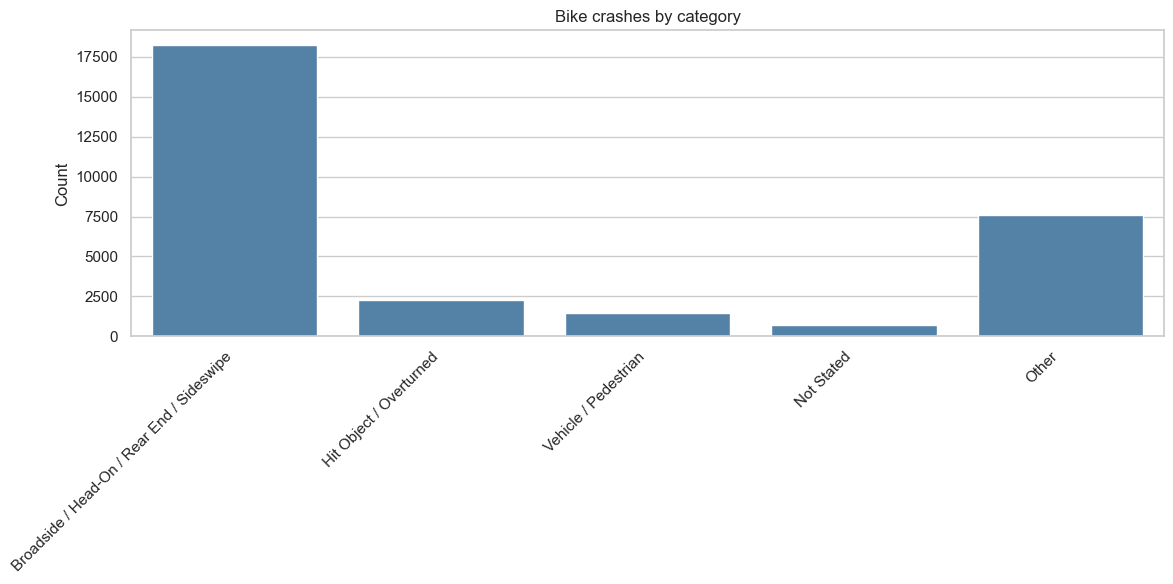

In [7]:
# Visual
order = [c for c in bike_by_cat['super_category'] if c != 'Other'] + (['Other'] if 'Other' in set(bike_by_cat['super_category']) else [])

plt.figure(figsize=(12, 6))
sns.barplot(data=bike_by_cat, x='super_category', y='count', order=order, color='#4682B4')
plt.title('Bike crashes by category')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### TL;DR (bikes)

- Bikes are about ~9% of all crashes.
- Most are vehicle–bike interactions (the big combined category).
- Big enough to be interesting — worth sampling a few dozen records.
- Hit object/overturned shows up but smaller.
- Focus on intersections/merges and driver‑yield behavior.

## Pedestrians


### How many ped crashes?

In [8]:
# Filter and size
ped_crash = crash_incident.query("is_pedestrian_crash == 't'")
ped_n = len(ped_crash)
ped_share = ped_n / len(crash_incident)
print(f"Ped crashes: {ped_n:,} ({ped_share:.1%} of all crashes)")

Ped crashes: 31,198 (9.5% of all crashes)


### Top factors


In [9]:
# Top primary factors (top 9 + other)
ped_factors = (
    ped_crash['primary_factor']
    .value_counts()
    .rename_axis('primary_factor')
    .reset_index(name='count')
)

top9 = ped_factors.head(9)
other = pd.DataFrame({'primary_factor': ['Other'], 'count': [ped_factors['count'][9:].sum()]})
top_nine = pd.concat([top9, other], ignore_index=True)

top_nine.assign(pct=lambda d: (d['count'] / d['count'].sum()) * 100)

,primary_factor,count,pct
0,Pedestrian Right of Way,12965,41.6
1,Pedestrian Violation,8129,26.1
2,Unsafe Speed,1914,6.1
3,Unknown,1574,5.0
4,Improper Turning,1183,3.8
5,Unsafe Starting or Backing,1155,3.7
6,Not Stated,1010,3.2
7,Traffic Signals and Signs,877,2.8
8,Automobile Right of Way,506,1.6
9,Other,1885,6.0


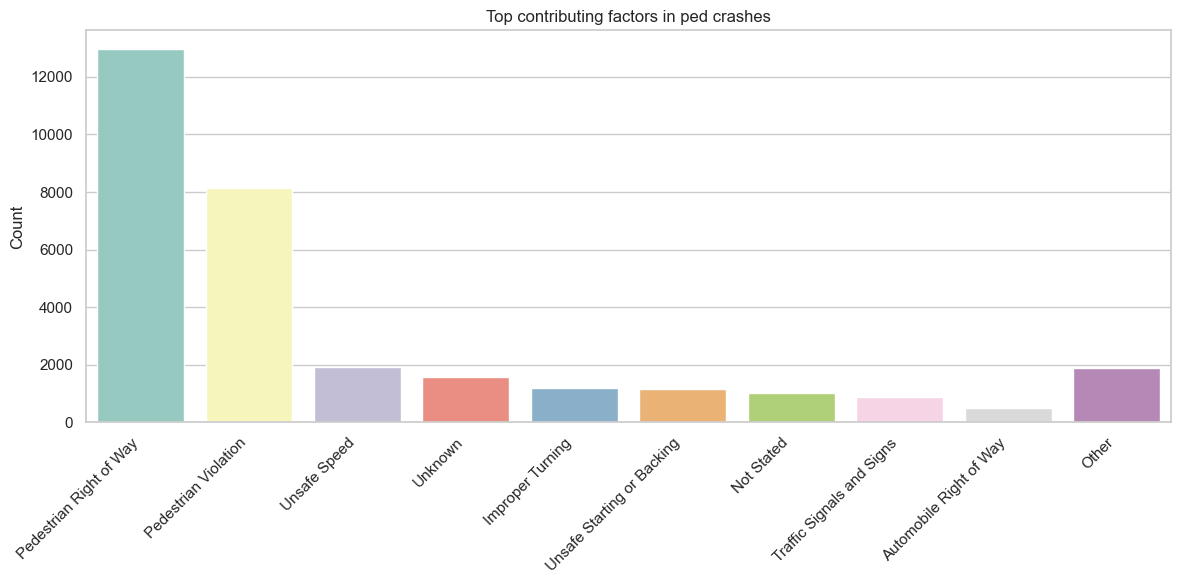

In [10]:
# Visual
plt.figure(figsize=(12, 6))
sns.barplot(data=top_nine, x='primary_factor', y='count', hue='primary_factor', palette='Set3', legend=False)
plt.title('Top contributing factors in ped crashes')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### TL;DR (peds)


- Peds are about ~9.5% of crashes.
- Right‑of‑way issues dominate; pedestrian violations show up next.
- Present, but smaller.
- Combine street design (clear priority) with targeted education and enforcement.

## The complicated ones (multi‑party)

### How many parties per crash?


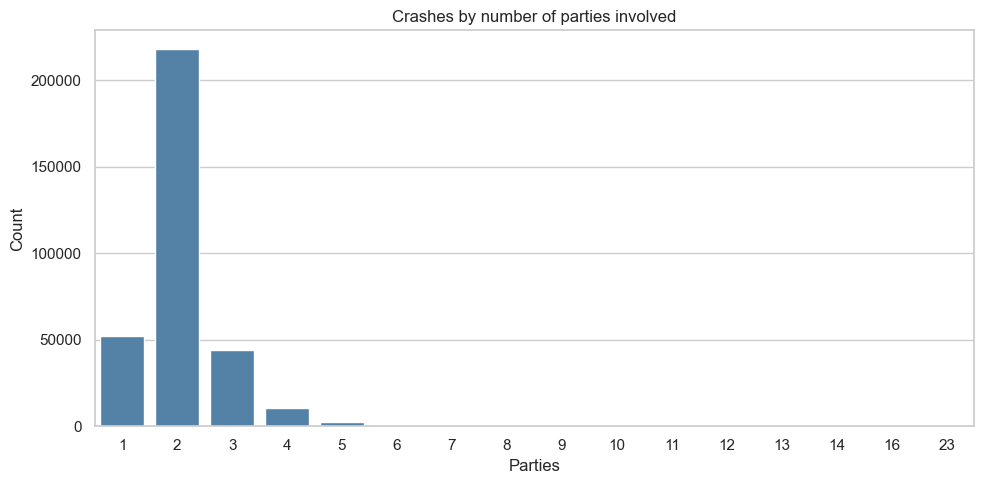

In [11]:
# Distribution of parties per crash
party_counts = (
    party.groupby('crash_incident_id')['party_number']
    .max()
    .value_counts()
    .sort_index()
)

party_counts.rename('count').to_frame()
plt.figure(figsize=(10, 5))
sns.barplot(x=party_counts.index, y=party_counts.values, color='steelblue')
plt.title('Crashes by number of parties involved')
plt.xlabel('Parties')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Severity vs number of parties


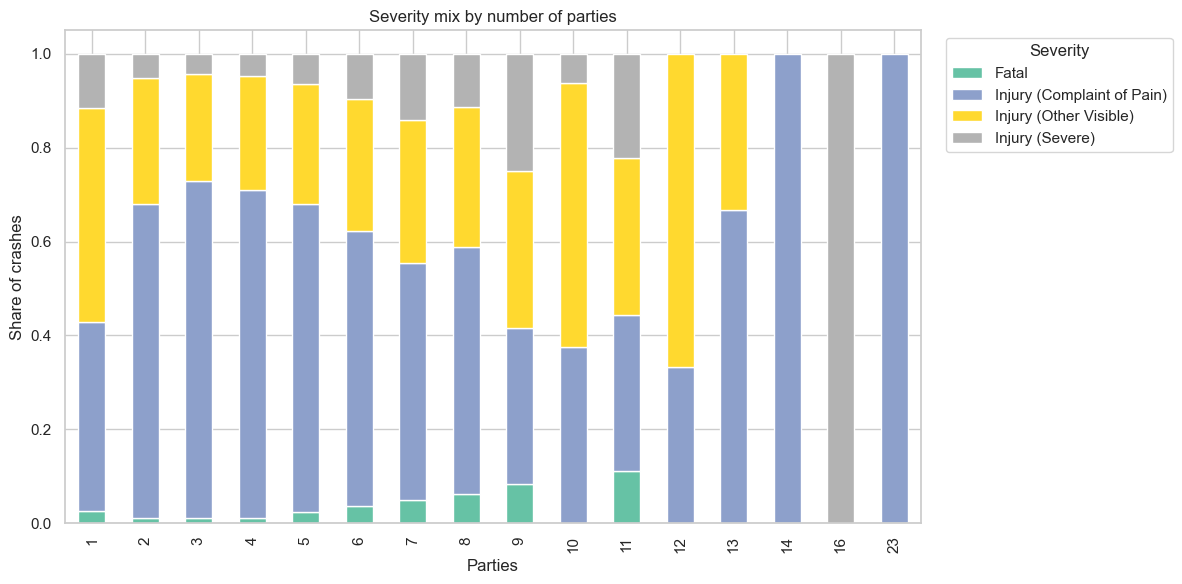

In [12]:
# Join crash severity with number of parties, then summarize
num_parties_by_crash = party.groupby('crash_incident_id')['party_number'].max().rename('num_parties')

severity_by_crash = crash_incident.set_index('id')[['severity']].join(num_parties_by_crash, how='inner')

counts = (
    severity_by_crash
    .groupby(['num_parties', 'severity'])
    .size()
    .rename('count')
    .reset_index()
)

pivot = counts.pivot(index='num_parties', columns='severity', values='count').fillna(0)
share = (pivot.T / pivot.T.sum()).T

# Plot share as stacked bars
ax = share.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
ax.set_title('Severity mix by number of parties')
ax.set_xlabel('Parties')
ax.set_ylabel('Share of crashes')
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
# Zoom in on 6+ party crashes
six_plus_ids = num_parties_by_crash[num_parties_by_crash >= 6].index
six_plus = (
    crash_incident.loc[crash_incident['id'].isin(six_plus_ids), 'severity']
    .value_counts()
    .rename('count')
    .to_frame()
)
six_plus.assign(pct=lambda d: (d['count'] / d['count'].sum()) * 100)

,count,pct
severity,,
Injury (Complaint of Pain),567,55.3
Injury (Other Visible),302,29.4
Injury (Severe),114,11.1
Fatal,43,4.2


## What we learned


- Bikes: ~9% of crashes; mostly vehicle–bike conflicts in intersection/merge contexts.
- Peds: ~9.5%; right‑of‑way dominates, then pedestrian violations; speed matters but smaller.

### What to try next
- Quick wins: daylighting, leading ped intervals, protected turns at conflict points.
- Bikes: protect the approach at intersections; simplify merge decisions.
- Peds: make priority obvious (design + signage), add targeted education/enforcement.
- Pull a sample from the "Other" bins to see what we’re missing.

Notes
- 328k incidents / 682k parties; light category standardization applied for readability.